## load dataset created at `structures_ds_non_pair.ipynb`

In [1]:
import os.path
from typing import Tuple

from datasets import Dataset

In [2]:
helix_ds_path = "/home/wzarzecki/ds_secondary_struct/helix_ds"
helix_ds = Dataset.load_from_disk(helix_ds_path)
helix_ds[0]

Loading dataset from disk:   0%|          | 0/28 [00:00<?, ?it/s]

{'values': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'structure_id': 'xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a',
 'timestep_id': tensor(1),
 'token_id': tensor(0),
 'secondary_struct': None,
 'helix': tensor(False)}

In [3]:
df = helix_ds.to_pandas()

In [4]:
df.head()

,values,structure_id,timestep_id,token_id,secondary_struct,helix
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a,1,0,None,False
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a,1,1,None,False
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a,1,2,None,False
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a,1,3,None,False
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",xxx_0_c4e8cf7d-8850-486c-8a9a-76f0b46a751a,1,4,E,False


In [5]:
df["helix"].value_counts()

helix
True     444800
False    287650
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split






group_df = df[['structure_id', 'helix']].drop_duplicates('structure_id')


train_ids, test_ids = train_test_split(
    group_df['structure_id'],
    test_size=0.2,
    stratify=group_df['helix'],
    random_state=42
)


train_df = df[df['structure_id'].isin(train_ids)]
test_df = df[df['structure_id'].isin(test_ids)]

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTrain set 'helix' distribution:")
print(train_df['helix'].value_counts(normalize=True))
print("\nTest set 'helix' distribution:")
print(test_df['helix'].value_counts(normalize=True))


Train set shape: (583750, 6)
Test set shape: (148700, 6)

Train set 'helix' distribution:
helix
True     0.606681
False    0.393319
Name: proportion, dtype: float64

Test set 'helix' distribution:
helix
True     0.609617
False    0.390383
Name: proportion, dtype: float64


In [7]:
train_df_small = train_df.sample(frac=1)
test_df_small = test_df.sample(frac=1)

## train logistic regression

fitting


/home/wzarzecki/miniforge3/envs/diffsae/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted
Accuracy: 0.8317
Balanced Accuracy: 0.8308
ROC AUC Score: 0.9280


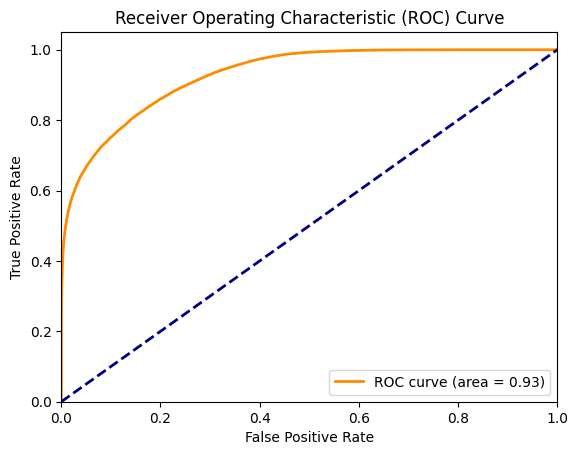

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


X_train = np.array(train_df_small['values'].tolist())
y_train = train_df_small['helix']
X_test = np.array(test_df_small['values'].tolist())
y_test = test_df_small['helix']



log_reg = LogisticRegression(class_weight='balanced') 
print("fitting")
log_reg.fit(X_train, y_train)
print("fitted")


y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

auc pr: 0.9548026210206824


/tmp/ipykernel_2488300/1314828657.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


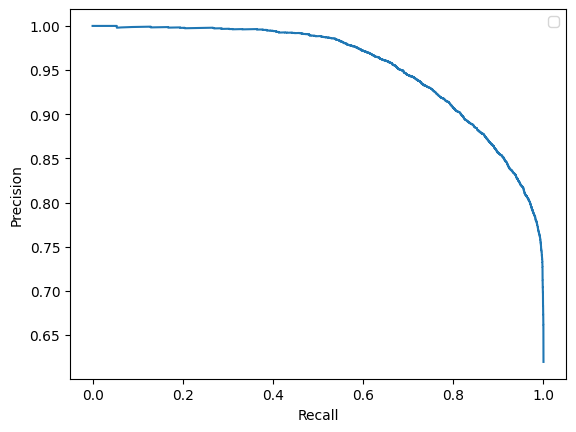

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

print(f"auc pr: {average_precision_score(y_test, y_pred_proba)}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()


## save coefs

In [ ]:
coefs_dir = "/home/wzarzecki/ds_secondary_struct/coefs/"
coefs_filename = "baseline_coef.npy"
bias_filename = "baseline_bias.npy"
ceofs_path = os.path.join(coefs_dir, coefs_filename)
bias_path = os.path.join(coefs_dir, bias_filename)

In [ ]:
np.save(coefs_paths, log_reg.coef_)
np.save(bias_path, log_reg.intercept_)

## top k biggest coefs prediction

In [ ]:
def prediction_top_k_biggest_coefs(X: np.array, coefs: np.array, bias: np.array, top_k: int) -> Tuple[np.array, np.array]:
    # sorted_indices = np.argsort(np.abs(coefs))[::-1]
    sorted_indices = np.argsort(np.abs(coefs[0]))[::-1]
    top_indices = sorted_indices[:top_k]
    top_k_coefs = coefs[0, top_indices]
    X_top_k = X[:, top_indices]
    logits = np.dot(X_top_k, top_k_coefs) + bias
    preds = (logits > 0).astype(int)
    probs = 1 / (1 + np.exp(-logits))
    return preds, probs

preds, probs = prediction_top_k_biggest_coefs(X_test, log_reg.coef_, log_reg.intercept_, 20)
preds.shape, probs.shape, preds[0], probs[0]

((14870,), (14870,), np.int64(1), np.float64(0.61862415851021))

In [ ]:
def predict_with_coefs(X: np.array, coefs: np.array, bias: np.array) -> Tuple[np.array, np.array]:
    logits = np.dot(X, coefs[0]) + bias
    preds = (logits > 0).astype(int)
    probs = 1 / (1 + np.exp(-logits))
    return preds, probs

preds, probs = predict_with_coefs(X_test, log_reg.coef_, log_reg.intercept_)
preds.shape, probs.shape, preds[0], probs[0]

((14870,), (14870,), np.int64(0), np.float64(0.002556130634396964))

In [ ]:
def mask_coefs(coefs: np.array, keep_k_biggest: int, masking_value: int = 0) -> np.array:
    sorted_indices = np.argsort(np.abs(coefs[0]))[::-1]
    top_indices = sorted_indices[:keep_k_biggest]
    mask = np.ones_like(coefs, dtype=bool)
    mask[:, top_indices] = False
    new_coefs = np.copy(coefs)
    new_coefs[mask] = masking_value
    return new_coefs

sample_coefs = np.random.rand(1, 4736)
new_coefs = mask_coefs(sample_coefs, 10)
np.sum(new_coefs > 0 )

np.int64(10)

In [ ]:
scores = {}
bias = log_reg.intercept_
all_coefs = log_reg.coef_
for k in range(100, 4736, 100):
    masked_coefs = mask_coefs(all_coefs, k)
    preds, probs = predict_with_coefs(X_test, masked_coefs, bias)
    scores[k] = {"balanced_accuracy": balanced_accuracy_score(y_test, preds), "auc_roc": roc_auc_score(y_test, probs)}
    print(k, scores[k])

100 {'balanced_accuracy': np.float64(0.5216799124735595), 'auc_roc': np.float64(0.5752608597068176)}
200 {'balanced_accuracy': np.float64(0.5322784636614922), 'auc_roc': np.float64(0.6014002787795941)}
300 {'balanced_accuracy': np.float64(0.7003173080950005), 'auc_roc': np.float64(0.7548304079292089)}
400 {'balanced_accuracy': np.float64(0.6757150578410007), 'auc_roc': np.float64(0.756756209476177)}
500 {'balanced_accuracy': np.float64(0.7360124591921247), 'auc_roc': np.float64(0.7934994171420348)}
600 {'balanced_accuracy': np.float64(0.7434024474490182), 'auc_roc': np.float64(0.7970246991998031)}
700 {'balanced_accuracy': np.float64(0.754680057950641), 'auc_roc': np.float64(0.8414427965333903)}
800 {'balanced_accuracy': np.float64(0.7823218065464073), 'auc_roc': np.float64(0.874962678692158)}
900 {'balanced_accuracy': np.float64(0.7891094836189028), 'auc_roc': np.float64(0.8908655798098146)}
1000 {'balanced_accuracy': np.float64(0.7887409084258128), 'auc_roc': np.float64(0.87680404866

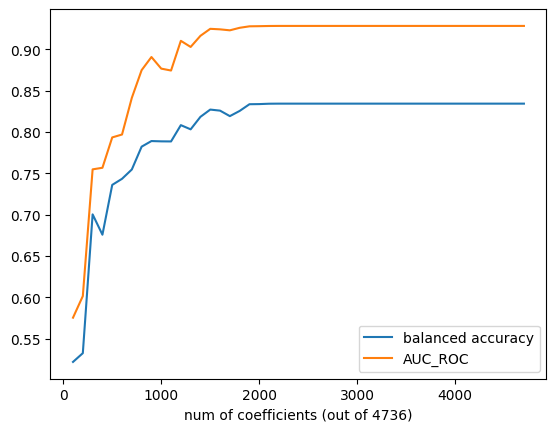

In [ ]:
plt.plot(scores.keys(), [scores[k]["balanced_accuracy"] for k in scores.keys()], label="balanced accuracy")
plt.plot(scores.keys(), [scores[k]["auc_roc"] for k in scores.keys()], label="AUC_ROC")
plt.legend()
plt.xlabel("num of coefficients (out of 4736)")
plt.show()

In [ ]:
all_coefs.shape

(1, 4736)

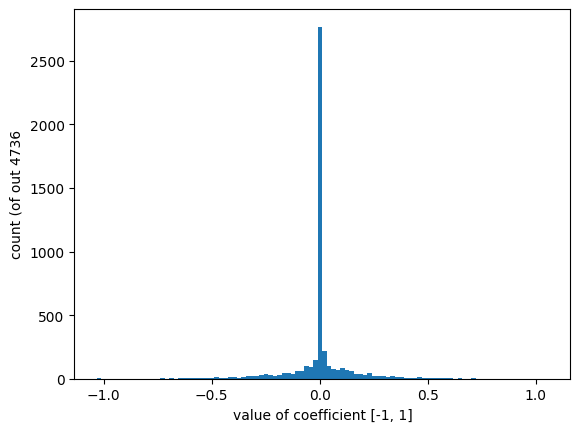

In [ ]:
plt.hist(np.sort(all_coefs[0]), bins=100)
plt.xlabel("value of coefficient [-1, 1]")
plt.ylabel("count (of out 4736")
plt.show()


## conversion to tuple of tensors

In [ ]:
import torch
torch.load("/home/wzarzecki/sae_interventions/long_sweep/500_1_50_.2/coefs/30/Cytoplasm_2_indices.pt")

/tmp/ipykernel_2488300/747326896.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/home/wzarzecki/sae_interventions/long_sweep/500_1_50_.2/coefs/30/Cytoplasm_

(tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,
          1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
         -1.,  1.]),
 tensor([3852,  796, 2150, 2241, 2227, 2381, 4451, 2067, 1325,  606,  207, 4630,
         3097, 2055, 2167, 4513,  324,  749, 1074, 2991, 2742, 2643, 4584, 4669,
         1424, 1689, 2893,  296, 3157, 1025]))

In [ ]:
from torch import Tensor

def get_top_k_indices(coef: np.ndarray, top_k: int, use_values_instead_of_sign: bool=False) -> Tuple[Tensor, Tensor]:
    coefs_torch = torch.from_numpy(coef[0]).float()
    abs_coefs = torch.abs(coefs_torch)
    indices = torch.topk(abs_coefs, k=top_k).indices
    values = coefs_torch[indices]
    if not use_values_instead_of_sign:
        values = torch.sign(values)
    return values, indices

get_top_k_indices(all_coefs, 100)

(tensor([ 1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
          1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,
         -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
          1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,
          1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
          1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
         -1.,  1.]),
 tensor([ 839,  922, 4534, 3979, 3482, 3967, 2322, 2916,  532,  221, 1056,  581,
         2222, 3373, 1543,  154,  952, 1989, 2406, 4641,  338, 1241, 3283, 2541,
         2369, 1657,  151, 2580,  427,  477, 4182, 3678, 2190, 3982, 1146, 4339,
         1914, 2663, 1497, 3661, 1795,   80, 1274, 3216, 4561, 4015, 3253, 4337,
         2102, 2320, 1290, 2572, 1192, 2831,  547, 3389, 2555, 1508, 3228, 4730,
         3244, 1871, 

In [ ]:
for k in [100, 250, 500, 1000, 2000]:
    masked_coefs = mask_coefs(all_coefs, k)
    torch.save(get_top_k_indices(masked_coefs, k), os.path.join(coefs_dir, f"baseline_top_{k}.pt"))